---
# <span style="font-size:25px;"> **Project:** Thermal error compensation
#  <span style="font-size:25px;"> **Machine:** 25TEX (SJE-10)
#  <span style="font-size:25px;"> **Phase:** P04 (Ansys simulation data)
# <span style="font-size:25px;"> **Activity:** Cross-validation for 80% training and 20% testing
# <span style="font-size:25px;"> **Model:** Regression Analysis
# <span style="font-size:25px;"> **Train:** 18 datasets 
# <span style="font-size:25px;"> **Test:** 4 datasets
---
# <span style="font-sixze:25px;"> **Description:**
#  <span style="font-size:20px;"> * Importing required libraties.
#  <span style="font-size:20px;"> * Specifiing the inputs.
#  <span style="font-size:20px;"> * Loading all datasets and merging into 1 datadrame.
#  <span style="font-size:20px;"> * Separating dependent and independent variables.
#  <span style="font-size:20px;"> * Seaprarting training and testing data.
#  <span style="font-size:20px;"> * Building XGboost model with hyperparamters.
#  <span style="font-size:20px;"> * fitting train data into model
#  <span style="font-size:20px;"> * predicting the test data.
#  <span style="font-size:20px;"> * Calculating the error estimation
#  <span style="font-size:20px;"> * Visualizing the results
---

# <span style="font-size:25px;"> **Author:** Shashank P
---

In [1]:
import xgboost as xgb
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

import onnxruntime.quantization as quant
from skl2onnx.common.data_types import FloatTensorType

✅ Chart created successfully inside Excel file!


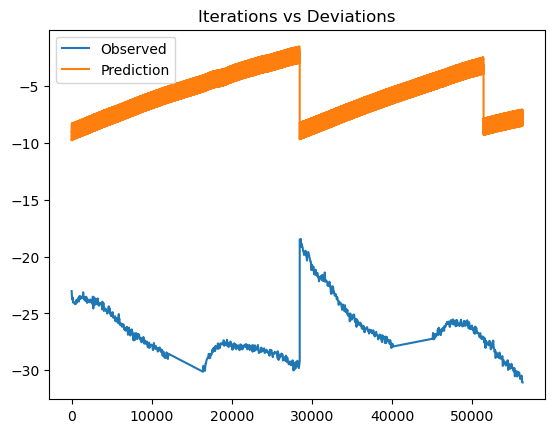

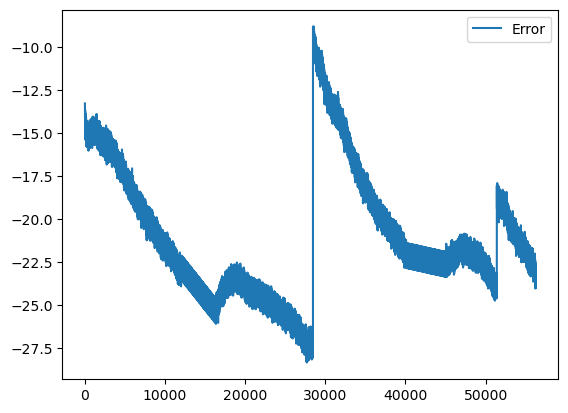

In [2]:
class ProjectConfig:
    def __init__(
        self,
        mother_path,
        machine_number,
        phase_number,
        model_folder,
        result_folder,
        result_file,
        ind_list,
        dep_list,
        val_files
    ):
        self.mother_path = mother_path
        self.machine_number = machine_number
        self.phase_number = phase_number
        self.model_folder = model_folder
        self.result_folder = result_folder
        self.result_file = result_file + ".xlsx"
        self.ind_list = ind_list
        self.dep_list = dep_list
        self.val_files = val_files

        self.project_path = (
            f"{mother_path}\\{machine_number}\\{machine_number}_{phase_number}"
        )

        self.train_path = (
            f"{self.project_path}\\{machine_number}_{phase_number}_{model_folder}"
        )

        self.dest_path = (
            f"{self.project_path}\\{machine_number}_{phase_number}_{result_folder}\\{self.result_file}"
        )



class DataLoader:
    def __init__(self, config: ProjectConfig):
        self.config = config

    def load_training_data(self):
        files = os.listdir(self.config.train_path)
        train_files = [f for f in files if f not in self.config.val_files]

        df_list = []
        for file in train_files:
            df = pd.read_excel(os.path.join(self.config.train_path, file))
            df_list.append(df)

        all_data = pd.concat(df_list)
        x = all_data[self.config.ind_list]
        y = all_data[self.config.dep_list]

        return x, y

    def load_validation_file(self, file_name):
        df = pd.read_excel(os.path.join(self.config.train_path, file_name))
        x = df[self.config.ind_list]
        y = df[self.config.dep_list]
        return x, y
    


class RegressionModel:
    def __init__(self):
        self.model = LinearRegression()

    def train(self, x, y):
        self.model.fit(x, y)

    def predict(self, x):
        return self.model.predict(x)
    

class Evaluator:
    @staticmethod
    def calculate_metrics(y_true, y_pred):
        error = y_true - y_pred

        metrics = {
            "R2": r2_score(y_true, y_pred),
            "RMSE": root_mean_squared_error(y_true, y_pred),
            "MAE": mean_absolute_error(y_true, y_pred),
            "MAPE": mean_absolute_percentage_error(y_true, y_pred),
            "Obs_band": np.max(y_true) - np.min(y_true),
            "Pred_band": np.max(y_pred) - np.min(y_pred),
            "Error_band": np.max(error) - np.min(error)
        }

        return metrics, error
    

class ResultWriter:
    def __init__(self, dest_path):
        self.dest_path = dest_path

    def write_results(self, summary_df, detailed_results):
        with pd.ExcelWriter(self.dest_path, engine="xlsxwriter") as writer:
            summary_df.to_excel(writer, sheet_name="file_detials", index=False)

            workbook = writer.book

            for i, df in enumerate(detailed_results, start=1):
                sheet_name = f"00{i + 6}"
                df.to_excel(writer, sheet_name=sheet_name, index=False)

                worksheet = writer.sheets[sheet_name]
                chart = workbook.add_chart({"type": "scatter"})

                max_row = len(df) + 1

                for col in ["Observed", "Prediction", "Error"]:
                    col_idx = df.columns.get_loc(col) + 1
                    chart.add_series({
                        "name": f"='{sheet_name}'!${chr(65+col_idx)}$1",
                        "categories": f"='{sheet_name}'!$A$2:$A${max_row}",
                        "values": f"='{sheet_name}'!${chr(65+col_idx)}$2:${chr(65+col_idx)}${max_row}",
                    })

                chart.set_x_axis({"name": "Time (sec)"})
                chart.set_y_axis({"name": "Deviation (µm)"})

                chart.set_chartarea({
                    "border": {"color": "black", "width": 2},
                    "fill": {"color": "#F8F8F8"}
                })

                worksheet.insert_chart("E2", chart, {"x_scale": 1.2})

        print("✅ Chart created successfully inside Excel file!")




class ThermalCompensationPipeline:
    def __init__(self, config: ProjectConfig):
        self.config = config
        self.loader = DataLoader(config)
        self.model = RegressionModel()
        self.writer = ResultWriter(config.dest_path)

    def run(self):
        x_train, y_train = self.loader.load_training_data()
        self.model.train(x_train, y_train)

        summary_list = []
        detailed_results = []

        metric_store = {"R2": [], "RMSE": [], "MAE": [], "MAPE": []}

        for file in self.config.val_files:
            x_val, y_val = self.loader.load_validation_file(file)
            y_pred = self.model.predict(x_val)

            metrics, error = Evaluator.calculate_metrics(y_val, y_pred)

            for k in metric_store:
                metric_store[k].append(metrics[k])

            summary_list.append(pd.DataFrame({
                "file name": [file],
                "X-dev band": [metrics["Obs_band"]],
                "X-pred band": [metrics["Pred_band"]],
                "X-error band": [metrics["Error_band"]],
                "R_2": [metrics["R2"]],
                "RMSE": [metrics["RMSE"]],
                "MAE": [metrics["MAE"]],
                "MAPE": [metrics["MAPE"]]
            }))

            df_detail = pd.DataFrame({
                "Iterations": np.arange(1, len(y_val) + 1),
                "Observed": y_val.values.flatten(),
                "Prediction": y_pred.flatten(),
                "Error": error.values.flatten()
            })

            detailed_results.append(df_detail)

        summary_df = pd.concat(summary_list).reset_index(drop=True)

        mean_df = pd.DataFrame({
            "Parameters": ["R2", "RMSE", "MAE", "MAPE"],
            "Mean values": [np.mean(metric_store[k]) for k in metric_store]
        })

        final_summary = summary_df.join(mean_df)

        self.writer.write_results(final_summary, detailed_results)

        self.plot_results(detailed_results)

    @staticmethod
    def plot_results(results):
        combined = pd.concat(results).reset_index()

        plt.plot(combined["Observed"], label="Observed")
        plt.plot(combined["Prediction"], label="Prediction")
        plt.legend()
        plt.title("Iterations vs Deviations")
        plt.show()

        plt.plot(combined["Error"], label="Error")
        plt.legend()
        plt.show()


config = ProjectConfig(
    mother_path="D:\\2.ProjectWork\\1.TEX",
    machine_number="25TEX_006",
    phase_number="P04",
    model_folder="10",
    result_folder="06",
    result_file="25TEX_006_P04_06_0211",
    ind_list=["F1", "F2", "F3", "F4", "F6"],
    dep_list=["D1"],
    val_files=[
        "25TEX_006_P03_04_251209.xlsx",
        "25TEX_006_P03_04_251210.xlsx"
    ]
)

pipeline = ThermalCompensationPipeline(config)
pipeline.run()